In [17]:
using DelimitedFiles
using Statistics
using StatsBase

include("../src/bin.jl")
include("../src/config.jl")
include("../src/crustDistribution.jl")
include("../src/invertData.jl")

using StatGeochem
using Plots; gr();

Loading crust information from file ../resources/crustDistribution.jld


In [101]:
build_args = readdlm("../data/remote/base/default_repeated_many/inversion_options.csv", ',', header=false)
N = build_args[findfirst(isequal("num_invert"), build_args[:,1]),2]
M = build_args[findfirst(isequal("num_runs"), build_args[:,1]),2]


10000

In [6]:
a = rand(100);

In [76]:
function find_age_aves(files, N, M)
	age_model = EarthChemAge(10, 3) # Default in inversion_binned_geotherm 
	ages = ageBins(age_model) 

	
    age_median = Array{Float64, 2}(undef, 3, length(ages)-1) # (layer, age)
	age_low = Array{Float64, 2}(undef, 3, length(ages)-1) # (layer, age)
	age_high = Array{Float64, 2}(undef, 3, length(ages)-1) # (layer, age) # 95 percentile


	for (l, file) in enumerate(files)	
		layer = LAYER_NAMES[l]

		(result, header) = readdlm(file, ',', header=true)
		header = header[:] # make 1d 

		si_index = findfirst(isequal("SiO2"), header) # result 
		age_index = findfirst(isequal("sample_age"), header) # Age 
		#good = ((.~isnan.(result[:,si_index])) .& (.~isnan.(result[:,age_index])))

		# Oversampling ratio -- IS THIS RIGHT???
		#n_original = length(crustDistribution.all_lats) # number of 1x1 grid cells w data 
		#n_resampled = size(result, 1) 

		for (i, age) in enumerate(ages[1:end-1])
			mc_avgs = fill(NaN, M)
			for m in 1:M
				# only this run 
				istart = (m-1)*N + 1
				iend = m*N
				dat = result[istart:iend, :]

				test = (dat[:,age_index] .>= age) .& (dat[:,age_index] .< ages[i+1])
				mc_avgs[m] = nanmean(dat[test,si_index])
            end
            
            check = .! isnan.(mc_avgs)
            age_median[l,i] = median(mc_avgs[check])
            age_low[l,i] = percentile(mc_avgs[check], 25)
            age_high[l,i] = percentile(mc_avgs[check], 75)
		end 
	end
	return ages, age_median, age_low, age_high
end 

find_age_aves (generic function with 2 methods)

In [102]:
files = ["../data/remote/base/default_repeated_many/results-$layer.csv" for layer in LAYER_NAMES]
ages, age_results, age_low, age_high = find_age_aves(files, N, M)

Using EarthChem age model


(0.0:400.0:4000.0, [62.31013210606061 61.77463272727273 … 60.612734 60.76379; 61.15225006410257 60.87403285714286 … 61.39179416666667 61.38775; 55.26426583333333 54.90166544642857 … 57.971762500000004 57.47267166666667], [61.03287528079711 59.60410625 … 57.226355 55.86628; 59.815695833333336 58.370785 … 57.964455 56.0463425; 54.11666794413919 53.14942108974359 … 54.883815 53.12898375], [63.542556690705126 63.98648599999999 … 63.97375833333333 65.32542; 62.466662425595246 63.15693 … 64.85296291666667 66.485505; 56.47756068181818 56.7758553125 … 61.003699250000004 61.9206375])

In [138]:
p1 = plot(legend=false, ylabel="% SiO2", ylims=(52, 70), title="Upper", titlefontsize=11) 
p2 = plot(legend=:bottomright, legendfontsize=7, fg_legend = :transparent, ylabel="% SiO2", ylims=(52, 70), title="Middle", titlefontsize=11)
p3 = plot(legend=false, xlabel="Age", ylabel="% SiO2", ylims=(52, 70), title="Lower", titlefontsize=11)
ps = [p1, p2, p3]

p = plot(size=(550,400), legend=:bottomright, fg_legend = :transparent, framestyle=:box, xlabel="Age", ylabel="SiO2 (weight %)");

for i in 1:3 # layers 
	color = [:blue, :orange, :green][i]
    plot!(p, ages[1:end-1].+i*10, age_results[i,:], 
        ribbon=(age_results[i,:].-age_low[i,:], age_high[i,:].-age_results[i,:]), 
        label=LAYER_NAMES[i], markerstrokecolor=color, fillalpha=.35,
        marker=true, markersize=3,
		linecolor=color, markercolor=color)
end 

In [139]:
# Plot exposed. Always use base so have same comparison... 
# TODO this will need to change when re-do base w new elts
tmin = 0
tmax = 4000
nbins = 5
samplePath = "../data/remote/base_nobin/bsr_ignmajors_1.csv"
ign, h = readdlm(samplePath, ',', header=true)
age_i = findfirst(isequal("Age"),PERPLEX_ELEMENTS)
si_i = findfirst(isequal("SiO2"),PERPLEX_ELEMENTS)
original = matread(IGN_FILE)
age_centers, elt_means, elt_errors = bin(ign[:,age_i], ign[:,si_i],
        tmin, tmax, length(ign[si_i])/length(original["SiO2"]), nbins)

#plot!(ps[1], age_centers, elt_means, color=:pink, 
#	yerror=elt_errors, label="exposed", markerstrokecolor=:auto);
#plot!(p, age_centers, elt_means, color=:black, 
#	 label="exposed", markerstrokecolor=:auto);

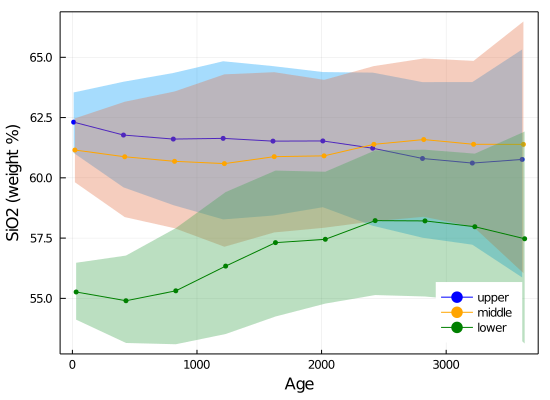

In [140]:
p

In [141]:
savefig(p, "../../THESIS/thesis/figures/age_comp.png")

In [41]:
age_low

3×10 Array{Float64,2}:
 57.7284  51.8364  48.0445  46.8417  …  47.5159  47.5004  48.1286  46.3366
 56.2143  50.9946  48.8955  48.9622     49.6111  49.6475  49.4801  47.5545
 51.3655  47.453   46.7208  46.7243     48.7103  46.4819  46.4903  45.1499

In [45]:
age_high

3×10 Array{Float64,2}:
 55.0676  45.9193  43.8458  44.2049  …  44.5353  43.1899  45.8931  45.8537
 55.0198  47.8969  46.0751  45.735      43.9863  46.1192  46.6342  45.1573
 50.3803  44.6956  44.1215  43.0363     43.8573  43.972   42.0197  43.3016

In [46]:
age_results

3×10 Array{Float64,2}:
 62.2029  61.9947  61.6398  61.622   …  60.8356  60.6497  60.5619  61.3665
 61.1135  60.9432  60.6759  60.8321     61.6987  62.0144  61.7513  61.6224
 55.188   54.8535  55.4436  56.1835     58.3814  58.1034  57.7435  57.8421

In [48]:
a = [61.124565, 62.12393068965517, 61.99939173913044, 56.33380923076923, 58.171793571428566, 60.700723513513516, 61.37173708333333, 63.060983125, 63.91700086956522, 63.40292935483871, 59.13775, 59.84727176470588, 62.45230615384615, 60.10643722222221, 58.10106, 62.26912611111111, 58.54688409090909, 59.54678272727272, 62.59975470588236, 62.90683833333333, 63.650355625, 60.59893947368421, 62.62941000000001, 57.91316636363637, 60.264883684210524, 63.933425, 63.977105, 62.44288230769231, 61.73563375, 63.92478178571429, 62.88829869565218, 62.703314999999996, 61.764439473684206, 61.715195263157895, 61.17335428571429, 60.15168166666667, 62.26912318181819, 61.297766, 62.653948, 64.41905157894737, 58.58888888888888, 63.39178090909092, 65.05694461538461, 63.923392857142865, 63.47918739130435, 64.97471761904762, 61.46859692307692, 58.70310680000001, 62.95419681818182, 61.386535, 61.88561541666667, 63.572602916666675, 66.05622866666666, 64.58083760000001, 62.8714972, 61.96392212121213, 62.250559583333335, 61.5164678125, 62.028724999999994, 63.238396111111115, 63.01076559999999, 63.76641545454545, 63.94785517241379, 62.555846521739134, 61.92891777777777, 61.832074999999996, 62.169293478260876, 61.3405373076923, 58.029069375000006, 59.61962052631579, 62.04517124999999, 63.17188, 60.952212380952375, 65.75492869565217, 61.165932999999995, 60.389337142857144, 62.33420210526315, 60.22790615384615, 59.919935833333334, 60.41152916666667, 60.05115692307693, 62.259086800000006, 63.186827916666665, 60.197648333333326, 63.53534277777778, 63.27246619047618, 64.16942333333334, 62.574187222222236, 62.62488608695652, 62.59688666666667, 65.1722575, 63.11597571428571, 60.83634210526316, 59.017913, 59.762608928571424, 60.90027772727273, 59.556780833333335, 61.95239827586207, 59.7465244, 65.36022666666668, 60.94504303030303, 61.87250740740741, 58.743778750000004, 62.90675388888889, 62.384860625, 59.13586214285715, 59.62832176470588, 60.135605, 59.098149, 61.39646058823528, 60.00835454545454, 61.50928714285715, 64.67951000000001, 64.466359, 61.804629999999996, 62.201882142857144, 65.19712166666666, 61.58230833333333, 63.22668937500001, 64.24253666666667, 63.71617904761904, 62.84385136363637, 60.65539826086957, 61.32760608695652, 61.389698499999994, 60.09578928571428, 65.70650944444444, 59.355660588235295, 63.66995181818181, 63.82044538461538, 60.415915454545456, 63.34508705882354, 66.3982623076923, 63.672360833333336, 61.72689849999999, 61.0724994736842, 62.15430904761905, 64.72030625000001, 63.13056000000001, 62.36117736842105, 63.88484148148148, 63.0961464516129, 61.89583125, 62.615566666666666, 62.56240233333333, 64.10629083333333, 63.69613027027026, 61.6218053125, 62.574858000000006, 61.81497208333334, 63.26706235294118, 63.70360466666667, 63.459444500000004, 61.60721068965518, 63.44732321428571, 61.26133304347826, 62.373881363636364, 61.371735333333326, 61.42603206896552, 62.55954538461538, 61.63043588235294, 62.93826440000001, 62.60932142857144, 63.26827049999999, 64.84389210526315, 62.67636947368421, 64.7203605, 59.56727272727273, 64.1148775, 64.92046909090908, 56.62606769230769, 61.460123333333335, 61.97915666666667, 62.35534736842106, 62.28944999999999, 62.71927684210526, 60.254138749999996, 61.929156, 62.880975263157886, 62.58743875, 64.79898466666667, 60.62136565217391, 59.92249464285714, 57.69400535714286, 63.0915796, 59.763949354838715, 60.033809999999995, 65.46969916666667, 61.52144545454546, 61.71495307692308, 62.130125500000005, 60.73150928571429, 63.03007, 62.21769578947368, 61.19346666666667, 61.4819452631579, 60.660628125, 58.65394238095238, 59.436719999999994, 60.725571666666674, 60.52264888888889, 64.22696315789474, 62.64002764705883, 57.764216923076916, 62.510930625, 62.8808468, 61.51221400000001, 63.075380833333334, 63.46489142857143, 64.00713571428571, 62.195235000000004, 60.88594166666667, 59.212641250000004, 61.33692111111111, 65.78281875, 63.31968764705883, 63.38496555555556, 58.983971818181814, 63.63125636363636, 65.764275, 61.640254705882356, 63.115944545454546, 63.48640913043478, 60.91256266666666, 62.50543454545455, 58.676279047619055, 62.948608148148146, 63.35268391304347, 61.26044181818181, 62.23556235294118, 62.2956828, 63.501306799999995, 63.98363, 63.746092999999995, 61.53365903225807, 62.849720714285716, 63.47281444444444, 61.00130629629629, 64.53271217391304, 59.436798181818176, 58.8164029032258, 63.62630045454545, 60.181864166666664, 61.4664625, 63.75598307692308, 64.17591291666666, 61.617880833333324, 63.61905458333333, 61.22872529411766, 62.36458954545455, 62.0510148275862, 61.01330545454545, 63.348850909090906, 62.155840000000005, 63.0730275, 60.65907, 60.87638818181817, 63.128989999999995, 58.0822375, 60.89354857142857, 63.32024625000001, 61.68163529411765, 57.36162071428571, 60.66214352941177, 61.68940142857142, 63.96407409090909, 60.992850588235285, 61.82924869565217, 62.9370344, 61.76493333333334, 60.19121749999999, 65.93566461538461, 58.241355483870976, 61.2224928, 59.87835222222222, 61.101256086956525, 58.74241416666666, 59.803124800000006, 62.62357791666667, 63.87037263157895, 62.92828206896552, 62.589693913043476, 61.037402, 59.61918176470588, 62.97437238095238, 60.64880818181818, 60.91025782608696, 59.181165625, 61.682975333333324, 61.63766277777778, 62.02859380952381, 59.87396111111111, 59.79987764705882, 60.960993333333334, 62.86272272727273, 64.08950315789474, 62.708844666666664, 63.06828785714286, 65.42766625, 61.99387764705882, 62.30335633333334, 63.67820421052632, 61.65767944444443, 64.25374357142857, 60.93776285714286, 63.971821250000005, 62.502487499999994, 63.33941176470588, 61.929801, 63.936803636363635, 61.9064375, 66.03374749999999, 61.602525, 63.047355555555555, 61.55394866666666, 64.34990416666666, 62.503205454545466, 58.76441111111111, 62.075670967741935, 65.5655477777778, 62.15897523809523, 63.14912043478262, 63.94004214285714, 63.202869615384614, 62.41332703703704, 62.683623749999995, 59.249504062499994, 59.496863870967736, 62.299361250000004, 65.96857607142857, 62.71805642857142, 63.4065256, 62.81331, 62.33520681818181, 60.75226923076923, 62.30708625, 60.800467000000005, 59.8771745, 61.798421000000005, 61.01078176470588, 61.63050347826088, 63.426444285714275, 62.17236588235294, 66.33750636363636, 63.8512312, 61.05867470588234, 62.275, 66.819699, 64.82443833333333, 61.03280941176472, 64.22705071428571, 60.337955, 60.960562499999995, 63.234795, 64.34772222222222, 62.55039055555556, 62.17727956521738, 60.80041421052633, 65.27149449999999, 61.81894227272726, 63.302264666666666, 61.83948749999999, 56.99946344827586, 60.528961153846154, 54.4956672, 59.928145416666666, 59.32969518518518, 63.20057115384615, 60.44421851851852, 65.168445625, 62.24781962962964, 62.149336000000005, 64.74174999999998, 58.73117066666667, 59.110052307692314, 60.635885625, 66.03601476190477, 60.6517961111111, 60.76797428571428, 62.35137050000001, 60.503766250000005, 61.18402666666666, 59.84867785714285, 59.75266315789474, 61.01191615384615, 63.134339, 60.50322545454546, 64.175479, 62.80691421052631, 64.35640631578949, 64.05971272727272, 63.8485296, 62.590265, 59.7348525, 61.46575166666668, 62.5051205882353, 61.454626499999996, 58.35355, 68.117283, 61.97509083333333, 62.86180444444445, 63.66692499999999, 63.43861142857143, 66.53558071428571, 63.65309333333334, 60.46070681818182, 63.215598125, 62.56379230769231, 64.68921458333334, 63.141585862068965, 64.25534400000001, 59.277617600000006, 65.1301784, 65.204002, 61.426527391304354, 64.87105571428572, 63.351530344827594, 62.7258276, 63.26289807692308, 62.570954444444446, 63.80252258064517, 63.35296, 62.97404304347826, 63.91418625, 60.63325695652174, 63.47570846153846, 63.04415904761905, 63.554362499999996, 61.67587565217392, 61.698755600000005, 62.43149526315789, 61.50380304347826, 60.95362666666667, 62.5272888888889, 62.58721592592592, 62.95234416666667, 63.91032882352941, 60.70016857142856, 61.07125666666667, 59.279822499999995, 63.89278166666667, 66.86554384615384, 62.36045375, 63.61152357142857, 63.463031818181825, 61.871051111111115, 66.82563666666667, 62.643195454545456, 64.19572857142857, 63.86299588235294, 61.95648333333333, 66.38428111111111, 59.63094730769231, 62.24693961538462, 59.55406166666666, 60.547850357142856, 60.85630888888889, 61.3207425, 63.494930625, 62.02360615384615, 62.21965166666667, 64.25274583333334, 60.64662466666666, 62.436745, 61.22198882352942, 67.85017416666666, 61.80908882352941, 60.3913719047619, 60.38518666666667, 61.1251055, 60.17319888888889, 62.64159736842106, 63.86638947368421, 61.35362789473684, 59.34603000000001, 62.727397894736846, 62.89007818181819, 62.53030125, 65.00268799999999, 60.51825157894737, 63.80006363636364, 62.082273888888885, 64.72202647058825, 59.939993529411765, 58.90278769230769, 63.44137550000001, 59.09264, 61.2485152631579, 62.207539999999995, 60.993088, 60.7064875, 61.82247888888888, 62.43317428571429, 62.48326312499999, 62.517412692307694, 61.1144609090909, 60.30599681818182, 61.63421, 62.79386999999999, 64.849605, 65.13326925925927, 64.96535565217391, 61.84816413793103, 60.49027676470588, 62.24572565217392, 62.82753968750001, 64.08401393939394, 63.651563, 64.05703703703703, 60.247392857142856, 64.130408, 64.90615666666666, 62.090693333333334, 62.36132666666667, 65.44678636363636, 63.607472800000004, 60.29531363636364, 62.20399692307693, 62.04521380952381, 61.461465000000004, 57.62934368421053, 62.261007037037025, 62.32358368421052, 60.91470611111111, 61.009083499999996, 62.99222, 62.27464199999999, 64.71420875, 61.188327692307695, 60.85074357142857, 64.89898444444445, 61.45649, 63.74933291666667, 63.42433090909091, 62.49343470588236, 61.88290294117646, 63.712421500000005, 64.44781956521739, 62.500325, 61.742604615384614, 58.95905882352941, 59.7850275862069, 58.73705409090908, 61.37050888888889, 60.311075357142855, 61.000012000000005, 61.99306217391305, 63.5150828, 61.707905789473685, 62.40330580645162, 61.55622294117647, 59.046353125, 64.45022523809523, 60.009698125, 61.713729090909084, 63.71287444444445, 61.427525, 60.75330695652173, 62.383046875, 59.79991736842105, 59.538122307692305, 62.14334388888889, 61.66379470588235, 62.42751533333333, 59.695166428571426, 61.270991249999994, 62.47792866666667, 65.0797888888889, 60.07665733333333, 61.95758666666666, 62.03655681818182, 66.48436375, 64.97229545454546, 59.442705333333336, 63.173135333333335, 60.23511333333334, 60.60652999999999, 60.846584375, 61.19220800000001, 63.18230499999999, 64.88946, 62.631644615384616, 62.02363, 62.68909235294118, 62.803990000000006, 59.08387291666667, 63.27518541666668, 62.23600235294118, 62.40338444444445, 62.51773911764706, 61.61171000000001, 61.796881875, 63.53912166666667, 62.404422, 62.71376925925925, 66.00449407407407, 63.310583076923066, 61.66488047619047, 64.08252384615385, 63.48387041666666, 61.93203199999999, 62.375668399999995, 60.85895541666667, 60.269016666666666, 62.33141320000001, 64.0494925, 62.00807423076923, 59.71942838709678, 62.679075000000005, 61.11766541666666, 63.627494, 62.43115235294118, 60.17206851851852, 63.15162764705883, 61.151819230769235, 62.64320066666666, 61.043061818181826, 59.56198500000001, 63.98968153846155, 64.4156155, 63.14172565217392, 61.73578, 61.86093666666667, 63.85047421052631, 64.474609375, 63.32800333333333, 63.68142380952381, 65.30583181818183, 63.02979761904763, 63.44874263157894, 61.37686, 61.377842400000006, 61.28804642857142, 59.65320192307692, 59.3158072, 58.83948935483871, 59.30570857142857, 63.106833913043474, 63.76627166666666, 62.32311937499999, 61.791478999999995, 58.30860769230769, 58.374524375, 59.33399, 58.536348333333336, 61.569149090909086, 63.570342916666675, 64.20651714285714, 61.52847578947369, 61.954130769230765, 60.026874, 62.104889333333325, 62.186395625, 65.67728071428571, 64.3539890909091, 61.3569864, 62.797824000000006, 60.84095736842105, 66.47133526315788, 62.34772695652173, 62.98263999999999, 58.607862352941176, 60.84329866666667, 61.285004545454555, 59.067866666666674, 60.857196666666674, 60.813145, 64.26929600000001, 61.710122, 62.650393636363646, 64.39762272727272, 62.233700666666664, 62.29048260869564, 67.96136249999999, 62.33366041666667, 58.17958708333333, 61.27733333333333, 61.56043476190476, 62.6279252173913, 63.18595785714285, 61.475892, 61.02089666666667, 60.40100733333334, 62.48358800000001, 62.3432976923077, 63.777854399999995, 63.20733920000001, 61.014927307692304, 61.09907090909091, 62.92299, 63.56116666666666, 62.08934434782609, 63.09156518518518, 60.28926166666666, 61.65020400000001, 63.96202280000001, 61.74029272727273, 62.8736555, 61.960055555555556, 61.45297925925925, 63.80817173913044, 63.3526992, 61.11832266666667, 60.320943125, 63.43951529411764, 62.742274615384616, 61.46992, 65.63436142857142, 59.636216875, 61.382985625, 61.345625, 64.5605425, 62.160560625, 63.2472308, 63.03248352941176, 63.731725, 61.06516200000001, 62.883693809523805, 62.29125565217391, 64.3643275, 61.067994444444444, 59.75864095238095, 62.74070199999999, 60.64174105263158, 58.494461785714286, 61.0194847826087, 60.16660357142858, 61.562273749999996, 61.28921962962963, 62.15842173913044, 59.27921777777778, 64.76620307692308, 59.039123333333336, 62.781634999999994, 59.745258235294116, 59.61923259259259, 60.37910750000001, 62.95240789473684, 59.541114444444446, 62.35427818181818, 59.58304538461539, 59.949620833333334, 62.74655357142858, 62.19111857142857, 61.82058086956521, 60.03712071428571, 64.37154047619048, 58.92827166666666, 62.807295999999994, 61.69669388888888, 63.208386785714296, 63.593870800000005, 62.18252705882354, 62.17916944444445, 63.92359941176472, 62.43611727272727, 62.99491476190476, 62.356114375, 65.1436090909091, 66.14057769230769, 63.10847846153846, 60.524046428571424, 63.00710666666667, 60.562001666666674, 63.75620588235295, 63.25888375, 60.18666260869565, 66.24845190476191, 61.7909476, 63.20943037037037, 62.216620869565226, 61.930416538461536, 65.6112964, 64.64358625, 62.09404678571428, 63.864318571428576, 61.98091827586207, 62.40867, 66.07552047619048, 61.76388566666666, 60.84943571428572, 63.89629565217392, 63.35781185185184, 61.83378961538462, 63.592888076923074, 60.45608909090909, 61.26670633333333, 61.37255105263157, 60.546598499999995, 58.577826400000006, 62.51251166666667, 62.328974210526304, 62.58876923076923, 62.2113135, 61.6792525, 61.742983684210515, 59.95355444444445, 62.49566818181818, 61.81010200000001, 61.040288000000004, 62.169341333333335, 60.387203125, 59.901079473684206, 61.273721904761906, 64.713709, 63.589259523809524, 65.01727263157895, 63.303396666666664, 61.107967826086956, 64.23283923076923, 64.24042588235295, 61.3951304, 59.22460523809524, 
58.75074111111111, 59.97647703703704, 60.19824458333334, 60.66698, 63.22823499999999, 63.86600758620689, 61.767275652173915, 60.057669, 61.84171529411765, 62.85561333333333, 62.01264285714286, 62.12383105263157, 61.753766500000005, 61.994685000000004, 58.038529411764706, 62.086985500000004, 64.95737388888888, 55.64073647058824, 62.95447727272728, 60.24011761904762, 61.964868124999995, 62.27474624999999, 62.90463952380952, 63.86253375, 64.79241705882353, 64.10874913043479, 64.42447111111112, 62.3702128, 60.5968745, 63.159034999999996, 62.978677272727275, 60.806780714285715, 60.74185764705882, 62.36874, 62.99303083333333, 59.050577, 63.23121916666667, 63.85402928571428, 61.78026, 60.69363071428571, 63.76551157894736, 60.55568045454545, 62.95802346153846, 61.3082736, 62.20763944444444, 61.54277035714285, 62.24744689655172, 61.158183529411765, 61.80683862068965, 63.79914130434782, 63.43652480000001, 62.248549677419355, 63.780758, 61.53563, 64.03669709677419, 62.20114620689655, 61.675482380952374, 62.267023, 60.236520625, 63.36596551724137, 58.14985, 62.870808999999994, 61.9910253125, 61.82442230769231, 64.95125, 60.07897611111111, 64.14781136363636, 61.88408333333333, 64.18516136363637, 62.97938892857144, 63.653650500000005, 63.43779, 61.359094999999996, 61.04403166666666, 63.55077300000001, 62.780066923076916, 63.52517909090909, 64.67710857142858, 60.52818549999999, 60.852609545454555, 61.793645454545455, 62.04204299999999, 62.94576, 64.7900194117647, 60.782928500000004, 63.07697615384616, 61.574515, 65.29680555555555, 61.14472826086957, 56.10408299999999, 58.490514399999995, 59.79587954545455, 59.475103999999995, 59.836798076923074, 63.03352538461539, 61.48041739130434, 63.09474639999999, 63.350776842105255, 58.73405125, 61.979419473684196, 62.59340454545454, 62.77695533333333, 59.92180764705883, 61.60893347826087, 61.58444565217392, 61.12562666666666, 60.72759583333334, 63.37620692307692, 61.19927647058824, 63.44390777777778, 62.258979473684214, 62.38989363636363, 62.25762933333333, 64.27982913043479, 66.29206238095239, 64.14875578947368, 61.45032529411765, 63.52815, 61.24450950000001, 64.23749909090908, 62.01156769230769, 60.26782647058823, 60.74802157894737, 64.17084500000001, 64.000294, 61.36907285714286, 62.22373285714286, 64.55904909090908, 61.71894307692308, 62.092030769230774, 63.586557777777784, 61.655423500000005, 61.77990173913043, 62.39168608695652, 62.278887999999995, 65.02726068965517, 58.993750909090906, 60.00530115384616, 63.82903, 61.19010565217392, 63.722024999999995, 62.98899962962963, 64.73462257142857, 63.40039838709678, 67.97904866666667, 63.23398642857143, 66.86837157894738, 64.1015256, 61.10594608695652, 61.87536894736841, 61.347071071428566, 62.78966333333334, 61.5897393939394, 61.342226666666676, 61.889077586206895, 60.67041588235294, 60.50497055555555, 63.19979857142857, 61.6049390909091, 62.04242631578948, 64.91561176470589, 59.874684, 59.787747, 62.66864599999999, 64.18087307692308, 61.12553454545454, 65.81431, 63.85495000000001, 59.44949117647059, 62.890358333333324, 63.10572578947369, 60.504595333333334, 62.65878411764705, 62.5641968, 64.227, 63.94470590909091, 67.2280725, 58.83602913043478, 60.34495931034483, 61.382702083333335, 60.32170045454546, 57.28406499999999, 59.6631292, 60.68823718750001, 62.64261, 61.84660699999999, 62.53348533333333]

1000-element Array{Float64,1}:
 61.124565
 62.12393068965517
 61.99939173913044
 56.33380923076923
 58.171793571428566
 60.700723513513516
 61.37173708333333
 63.060983125
 63.91700086956522
 63.40292935483871
 59.13775
 59.84727176470588
 62.45230615384615
  ⋮
 63.94470590909091
 67.2280725
 58.83602913043478
 60.34495931034483
 61.382702083333335
 60.32170045454546
 57.28406499999999
 59.6631292
 60.68823718750001
 62.64261
 61.84660699999999
 62.53348533333333

In [54]:
percentile(a, 5)

59.04599163541667

In [51]:
median(a)

62.20293953296704

In [105]:
name = "remote/base/default_repeated_many"

"remote/base/default_repeated_many"

In [106]:
ures, h = readdlm("../data/$name/results-upper.csv", ',', header=true)
mres, h = readdlm("../data/$name/results-middle.csv", ',', header=true)
lres, h = readdlm("../data/$name/results-lower.csv", ',', header=true)

([2912.258718217815 6.889765764905635 … 0.0 2.0; 2905.130843663394 6.873603163873149 … 0.0 3.0; … ; 2915.175636331067 6.806003834690372 … 0.0 3.0; 2923.7393463288167 6.883193114600455 … 0.0 3.0], AbstractString["sample_rho" "sample_vp" … "exhumed" "bin"])

In [107]:
si_i = findfirst(isequal("SiO2"), h[:]);

In [108]:
resu = zeros(M,3)

for (l, res) in enumerate([ures, mres, lres])
    for i in 1:M
        istart = (i-1)*N + 1
        iend = i*N
        #println(nanmean(res[istart:iend, si_i]))
        resu[i,l] = nanmean(res[istart:iend, si_i])
    end
end

In [156]:
colors = [:blue, :orange, :green]
stephist(resu[:,1], normalize=:pdf, label="Upper", c=colors[1])
stephist!(resu[:,2], normalize=:pdf, label="Middle", c=colors[2])
stephist!(resu[:,3], normalize=:pdf, label="Lower", c=colors[3])
scatter!([66.6], [1/100], c=:black, shape=:diamond, label="Rudnick & Gao (2014)", legend=:outerright)
scatter!([66.6], [1/100], c=colors[1], label=false, shape=:diamond)
scatter!([63.5], [1/100], c=colors[2], label=false, shape=:diamond)
scatter!([53.4], [1/100], c=colors[3], label=false, shape=:diamond)
plot!(yticks=false, framestyle=:box, xlabel="SiO2", size=(600, 200))
savefig("../../THESIS/thesis/figures/comp.png")